In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn import ensemble
import joblib

Učitavanje podataka i preprocesiranje su isti kao i u prethodnoj datoteci.

In [3]:
data = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='latin-1', header=None, names=['Sentiment', 'Tweet ID', 'Date', 'Query', 'Username', 'Tweet'])


In [4]:
def Sentiment_remap(x):
    if x == 0:
        return 0
    else:
        return 1

In [5]:
data['Sentiment'] = data['Sentiment'].apply(Sentiment_remap)

In [6]:
x = data['Tweet']
y = data['Sentiment']

In [7]:
tweet_count_vectorizer = CountVectorizer()

In [29]:
x_train_validation, x_test, y_train_validation, y_test = train_test_split(x,y,test_size=0.33, stratify=y, random_state=7)

In [37]:
x_train_validation.shape

(1072000,)

In [30]:
x_train, x_validation, y_train, y_validation = train_test_split(x_train_validation ,y_train_validation , stratify=y_train_validation, test_size=0.33, random_state=42)

In [31]:
tweet_count_vectorizer.fit(x_train)

CountVectorizer()

In [32]:
x_train_validation_vectorized = tweet_count_vectorizer.transform(x_train_validation)
x_train_vectorized = tweet_count_vectorizer.transform(x_train)
x_validation_vectorized = tweet_count_vectorizer.transform(x_validation)
x_test_vectorized = tweet_count_vectorizer.transform(x_test)

# MODEL 1 - Slučajne šume



Upoređuju se tačnosti šesnaest modela slušajnih šuma različitih vrednosti maksimalne dubine stabala i broja stabala. 

In [33]:
n_estimators = [10, 20, 30, 40]
max_depths = [5, 10, 20, 30]

all_scores = []
best_n_estimators = None
best_max_depth= None
best_f1_Score = 0

for n_estimator in n_estimators:
    for max_depth in max_depths:
        model1 = ensemble.RandomForestClassifier(n_estimators=n_estimator, max_depth=max_depth, random_state=7)  
        model1.fit(x_train_vectorized, y_train)
        y_validation_predicted = model1.predict(x_validation_vectorized)
        f1_Score = f1_score(y_validation, y_validation_predicted)
        all_scores.append(f1_Score)
        if f1_Score > best_f1_Score:
            best_n_estimators = n_estimator
            best_max_depth = max_depth
            best_f1_Score = f1_Score

Sa slike se može uočiti da tačnost raste sa povećanjem maksimalne dubine stabala. Međutim, porast se smanjuje što ka svakom sledećem modelu. 

In [34]:
all_scores

[0.374748768153527,
 0.44149829909598365,
 0.6871234725099299,
 0.7032531002246595,
 0.41324077354648564,
 0.4992913902148392,
 0.6989761198123533,
 0.7222448454713019,
 0.6846451058958214,
 0.692821719018036,
 0.7194807768529529,
 0.7378661985150927,
 0.6808195695632048,
 0.6926749102090043,
 0.7198059243017942,
 0.7381629970780879]

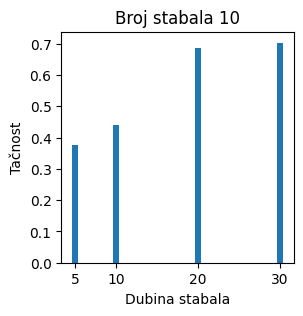

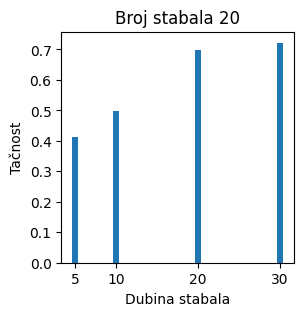

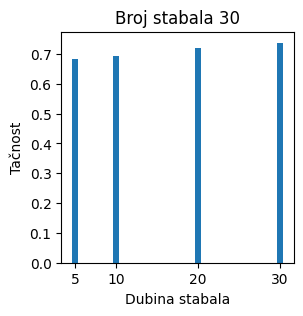

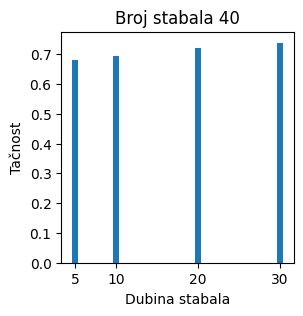

In [35]:
count_depth = 0
count_n = 0
score_index = 0
while count_n < 4:
    plt.figure(figsize=(3, 3))
    plt.xticks([5, 10, 20, 30])  
    plt.ylabel("Tačnost")
    plt.xlabel("Dubina stabala")
    plt.title(f"Broj stabala {n_estimators[count_n]}")     
    plt.bar([5, 10, 20, 30], [all_scores[i] for i in range(score_index, score_index + 4 ,1)])
    score_index = score_index + 4
    count_n += 1
    


In [36]:
best_model1 = ensemble.RandomForestClassifier(n_estimators=best_n_estimators, max_depth=best_max_depth, random_state=42)
best_model1.fit(x_train_validation_vectorized, y_train_validation)

RandomForestClassifier(max_depth=30, n_estimators=40, random_state=42)

In [38]:
y_predicted1 = best_model1.predict(x_test_vectorized)

In [39]:
print(classification_report(y_test, y_predicted1))

              precision    recall  f1-score   support

           0       0.75      0.67      0.71    264000
           1       0.70      0.77      0.73    264000

    accuracy                           0.72    528000
   macro avg       0.72      0.72      0.72    528000
weighted avg       0.72      0.72      0.72    528000



In [40]:
joblib.dump(best_model1, 'slucajne_sume.pkl')

['slucajne_sume.pkl']

Tačnost su propratile i ostale evaluacione mere koje su imale slične vrednosti. 


# MODEL 2 - Prosta agregacija



Sličan stvar se radi i za prostu agregaciju. Kod nje je postavljeno i veći broj stabala zbog loših rezultata koje je pokazalo sa malim vrednostima. Sve vrednosti koje su kontantne su postavljene na svoju maksimalnu vrednost da bi modeli mogli da se kreiraju u prihvatljivom vremenu.

In [42]:
accs2 = []
for i in range(4,25, 4):
    model2 = ensemble.BaggingClassifier(tree.DecisionTreeClassifier(max_depth=10 ,random_state=42), n_estimators=i*3, max_samples=i, bootstrap=True, random_state=7)
    model2.fit(x_train_vectorized, y_train)
    y_predicted2 = model2.predict(x_test_vectorized)
    accs2.append(accuracy_score(y_test, y_predicted2))


<BarContainer object of 6 artists>

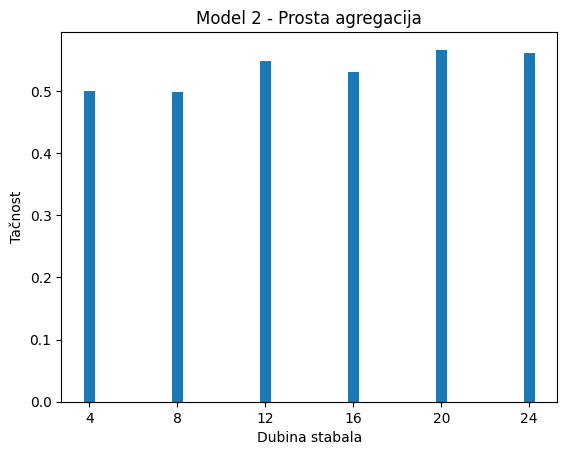

In [43]:
plt.xticks(range(4, 25, 4))  
plt.ylabel("Tačnost")
plt.xlabel("Dubina stabala")
plt.title("Model 2 - Prosta agregacija")
plt.bar(range(4, 25, 4), accs2, width=0.5)

In [44]:
print(classification_report(y_test, y_predicted2))

              precision    recall  f1-score   support

           0       0.61      0.33      0.43    264000
           1       0.54      0.79      0.64    264000

    accuracy                           0.56    528000
   macro avg       0.58      0.56      0.54    528000
weighted avg       0.58      0.56      0.54    528000



Razlog zašto ovakav model radi lošije od običnih slučajnih šuma je baš taj što se oslanja na greške prethodnih modela. Forma modela slučajnih šuma nije adekvatna za rad sa ovakvim skupom podataka jer ne obuhvata smisao rečenica, a pokušaj da se iskoristi takav model i iz njega izvuče korisna informacija dovodi do još gorih rezultata.

# MODEL 3 - Pojačavanje (XG Boost)



Kao i u prethodim primerima, maksimalna dubina će se varirati i u pojačanju gradijentnim spustom.

In [8]:
import xgboost

Kad se uzme ceo skup podataka ovaj metod neće funkcionisati jer dolazi do pucanja kernela. Zato je uzet manji broj podataka. Takođe je stavljen i manji broj varijacije hiperparametra.

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x,y,train_size = 0.1, test_size=0.04, stratify=y, random_state=7)

In [10]:
tweet_count_vectorizer.fit(x_train)

x_train_vectorized = tweet_count_vectorizer.transform(x_train)
x_test_vectorized = tweet_count_vectorizer.transform(x_test)

In [11]:
accs3 = []
for i in range(4,16, 4):
    model3= xgboost.XGBRegressor(objective='reg:squarederror', n_estimators=10, max_depth=i)
    model3.fit(x_train_vectorized, y_train)
    y_predicted3 = model3.predict(x_test_vectorized)
    accs3.append(model3.score(x_test_vectorized, y_test))

In [12]:
from sklearn import metrics
metrics.mean_squared_error(y_test, y_predicted3)

0.19777692829765178

<BarContainer object of 3 artists>

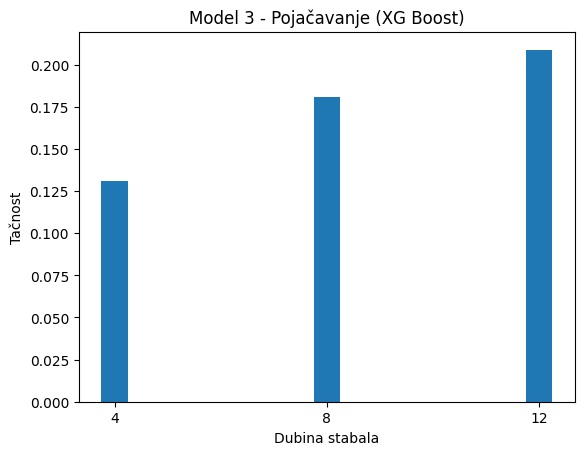

In [14]:
plt.xticks(range(4, 16, 4))  
plt.ylabel("Tačnost")
plt.xlabel("Dubina stabala")
plt.title("Model 3 - Pojačavanje (XG Boost)")
plt.bar(range(4, 16, 4), accs3, width=0.5)

Proširivanjem slabala se povećava srednjekvadratna greška. Ono što se može zaključiti da gradijentni spust definitivno ima kontra efekat na klasifikaciju ovakvog skupa podataka.